In [1]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch, os
from torch.utils.data import Dataset
from ipywidgets import interact 
import seaborn as sns
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import tensorflow as tf
import numpy as np

In [2]:
torch.__version__

'2.1.0'

# Loading Data

In [3]:
dataset = load_dataset("trec")
train_dataset = dataset['train']
test_dataset = dataset['test']

In [4]:
train_df = pd.DataFrame({'text' : train_dataset['text'], 'coarse_label' : train_dataset['coarse_label']})
test_df = pd.DataFrame({'text' : test_dataset['text'], 'coarse_label' : test_dataset['coarse_label']})

In [5]:
train_df.head()

,text,coarse_label
0,How did serfdom develop in and then leave Russ...,2
1,What films featured the character Popeye Doyle ?,1
2,How can I find a list of celebrities ' real na...,2
3,What fowl grabs the spotlight after the Chines...,1
4,What is the full form of .com ?,0


In [6]:
from sklearn.model_selection import train_test_split
initial_labeled_set, pool = train_test_split(train_df, test_size=0.95, stratify=train_df['coarse_label'])

In [7]:
initial_labeled_set

,text,coarse_label
4332,Where does the U.S. rank among world countries...,5
2159,What is a heuristic ?,2
2529,What is a hydrogen bond ?,2
609,What was the name of the 187s Irish terrorist ...,3
2517,What South American capital is the world 's hi...,4
...,...,...
3637,How can I give myself a French manicure ?,2
4803,What non-mechanical sport achieves the highest...,1
2922,"What shampoo prevents eczema , seborrhea , and...",1
4898,How do I find out the exact time of a sunset f...,2


# Spliting Data into train_encodings, test_encodings

In [8]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)

In [9]:
train_encodings = tokenizer(initial_labeled_set['text'].to_list(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['text'].to_list(), truncation=True, padding=True)
train_labels = initial_labeled_set.coarse_label.to_list()
test_labels = test_df.coarse_label.to_list()

In [10]:
num_labels = 6
id_to_label = {0 : 'ABBR' , 1 : 'ENTY', 2: 'DESC', 3 : 'HUM', 4 : 'LOC', 5 : 'NUM'}
label_to_id= { 'ABBR' : 0 , 'ENTY' : 1, 'DESC': 2, 'HUM' :3, 'LOC' : 4, 'NUM' : 5}

In [11]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, id2label = id_to_label, label2id = label_to_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### TrainingArguments, Dataloader, Metrics are needed to construct this Fine-tune the model

In [12]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./BERTModel2',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
)

In [13]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        """
          This construct a dict that is (index position) to encoding pairs.
          Where the Encoding becomes tensor(Encoding), which is an requirements
          for training the model
        """
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        """
        Returns the number of data items in the dataset.

        """
        return len(self.labels)

In [14]:
def compute_metrics(pred):

    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro',zero_division=1)

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

# Calling our Dataloader

In [15]:
train_dataloader = DataLoader(train_encodings,train_labels)
test_dataloader = DataLoader(test_encodings,test_labels)

In [16]:
trainer = Trainer(
    #the pre-trained bert model that will be fine-tuned
    model=model,
    #training arguments that we defined above
    args=training_args,
    train_dataset= train_dataloader,
    eval_dataset = test_dataloader,
    compute_metrics= compute_metrics
)

 Evaluate the prediction accuracy of our model on the dataset without training or fine-tuning it

In [17]:
predictions = trainer.predict(test_dataloader)


  0%|          | 0/16 [00:00<?, ?it/s]

In [18]:
predicted_labels = predictions.predictions.argmax(axis=1)


In [19]:
accuracy = accuracy_score(test_df['coarse_label'].to_list(),predicted_labels)
print('accuracy {} '.format(accuracy))

accuracy 0.052 


## An Active Learning Approach Based On Uncertain Sampling

In [20]:
initial_labeled_set.head() # so we fine_tune with the inital_labeled data

,text,coarse_label
4332,Where does the U.S. rank among world countries...,5
2159,What is a heuristic ?,2
2529,What is a hydrogen bond ?,2
609,What was the name of the 187s Irish terrorist ...,3
2517,What South American capital is the world 's hi...,4


In [21]:
initial_labeled_set.shape

(272, 2)

# 

In [22]:
def entropy_for_each_row(class_probabilities):
    """ Calculate entropy for each row in the array """
    return -tf.reduce_sum(class_probabilities * tf.math.log(class_probabilities),axis=1)

In [23]:
data = test_df.copy()

In [24]:
data['coarse_label']

0      5
1      4
2      3
3      2
4      5
      ..
495    3
496    1
497    5
498    1
499    2
Name: coarse_label, Length: 500, dtype: int64

In [25]:
def predict_and_calculate_entropy(data):
    ''' Sample the Data '''
    data_encodings = tokenizer(data['text'].to_list(), truncation=True, padding=True)
    dataloader = DataLoader(data_encodings, data.coarse_label.to_list())

    ''' Make predictions with class_probabilities and calculate entropy (uncertainty) '''
    predictions = trainer.predict(dataloader)
    prediction_probabilities = tf.constant(predictions.predictions)

    ''' Predicted Labels '''
    predicted_labels = predictions.predictions.argmax(axis=1)

    

    ''' Prediction Probabilities '''
    # Prediction probabilities, returning the highest probability for each instance
    prediction_probabilities_max = np.amax(prediction_probabilities, axis=1)

    # Calculate entropy for each instance
    entropies = entropy_for_each_row(tf.nn.softmax(prediction_probabilities))

    entropy_df = pd.DataFrame(
        {'text' : data['text'].to_list(),
         'predicted_Label': predicted_labels,
         'predicted_Probability': prediction_probabilities_max,
         'Entropy': entropies},
        index=data.index
    )

    final_df = pd.concat([data['coarse_label'], entropy_df], axis=1)

    return final_df.sort_values(by=['Entropy'],ascending=False)


In [26]:
def finetune_and_train(data):

    data_encodings = tokenizer(data['text'].to_list(), truncation=True, padding=True)
    data_labels = data.coarse_label.to_list()

    test_encodings = tokenizer(test_df['text'].to_list(), truncation=True, padding=True)
    test_labels = test_df.coarse_label.to_list()

    #Create Dataloader
    train_dataloader = DataLoader(data_encodings,data_labels)
    test_dataloader = DataLoader(test_encodings,test_labels) 


    trainer = Trainer(
        #the pre-trained bert model that will be fine-tuned
        model=model,
        #training arguments that we defined above
        args=training_args,
        train_dataset= train_dataloader,
        eval_dataset = test_dataloader,
        compute_metrics= test_dataloader
    )

    trainer.train()



In [27]:
# Initialize empty lists to store metrics for each iteration
accuracy_list = []
precision_list = []
recall_list = []
loss_list = []
x_labels = []
n = 0

for iteration in range(10):
    
    sample_data = data.sample(n=10,random_state=42)
    data.drop(sample_data.index,inplace = True)
    entropy_prob_df = predict_and_calculate_entropy(sample_data)

    #Let now apply active learning
    text_encoding = tokenizer(entropy_prob_df['text'].to_list(),truncation=True,padding=True)
    sample_dataloader = DataLoader(test_encodings, entropy_prob_df.coarse_label.to_list())

    #test_df 
    test_encodings = tokenizer(test_df['text'].to_list(),truncation=True,padding=True)
    test_dataloader = DataLoader(test_encodings, test_df.coarse_label.to_list())

    trainer = Trainer(
        #the pre-trained bert model that will be fine-tuned
        model=model,
        #training arguments that we defined above
        args=training_args,
        train_dataset= train_dataloader,
        eval_dataset = test_dataloader,
        compute_metrics= compute_metrics
    )

    trainer.train()

    metrics = trainer.evaluate()

    n += 10

    accuracy_list.append(metrics['eval_Accuracy'])
    precision_list.append(metrics['eval_Precision'])
    recall_list.append(metrics['eval_Recall'])
    loss_list.append(metrics['eval_loss'])
    x_labels.append(n)



    
    

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

{'loss': 1.6625, 'learning_rate': 2.5e-05, 'epoch': 2.94}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 1.3287774324417114, 'eval_Accuracy': 0.668, 'eval_F1': 0.49803209580482344, 'eval_Precision': 0.769257447161347, 'eval_Recall': 0.5372530478781109, 'eval_runtime': 0.9964, 'eval_samples_per_second': 501.816, 'eval_steps_per_second': 16.058, 'epoch': 2.94}
{'train_runtime': 10.9457, 'train_samples_per_second': 74.55, 'train_steps_per_second': 4.659, 'train_loss': 1.6514750648947323, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

{'loss': 1.1521, 'learning_rate': 2.5e-05, 'epoch': 2.94}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.9886281490325928, 'eval_Accuracy': 0.744, 'eval_F1': 0.5885634006383904, 'eval_Precision': 0.8209782374488257, 'eval_Recall': 0.6133262856743519, 'eval_runtime': 1.0123, 'eval_samples_per_second': 493.93, 'eval_steps_per_second': 15.806, 'epoch': 2.94}
{'train_runtime': 10.9664, 'train_samples_per_second': 74.409, 'train_steps_per_second': 4.651, 'train_loss': 1.145250717798869, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

{'loss': 0.7407, 'learning_rate': 2.5e-05, 'epoch': 2.94}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.6323564648628235, 'eval_Accuracy': 0.894, 'eval_F1': 0.7502006274361395, 'eval_Precision': 0.9168212469679208, 'eval_Recall': 0.7550976308319785, 'eval_runtime': 1.0124, 'eval_samples_per_second': 493.863, 'eval_steps_per_second': 15.804, 'epoch': 2.94}
{'train_runtime': 10.9532, 'train_samples_per_second': 74.499, 'train_steps_per_second': 4.656, 'train_loss': 0.7342329013581369, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

{'loss': 0.3465, 'learning_rate': 2.5e-05, 'epoch': 2.94}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.4681198298931122, 'eval_Accuracy': 0.878, 'eval_F1': 0.7404430368471023, 'eval_Precision': 0.8989556103648373, 'eval_Recall': 0.7524566918212137, 'eval_runtime': 1.0103, 'eval_samples_per_second': 494.884, 'eval_steps_per_second': 15.836, 'epoch': 2.94}
{'train_runtime': 10.9787, 'train_samples_per_second': 74.326, 'train_steps_per_second': 4.645, 'train_loss': 0.34340673889599593, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

{'loss': 0.1078, 'learning_rate': 2.5e-05, 'epoch': 2.94}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.6771721839904785, 'eval_Accuracy': 0.81, 'eval_F1': 0.6935978621684887, 'eval_Precision': 0.87553115953175, 'eval_Recall': 0.7105363924489666, 'eval_runtime': 1.005, 'eval_samples_per_second': 497.493, 'eval_steps_per_second': 15.92, 'epoch': 2.94}
{'train_runtime': 10.9912, 'train_samples_per_second': 74.241, 'train_steps_per_second': 4.64, 'train_loss': 0.11098112253581777, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

{'loss': 0.0435, 'learning_rate': 2.5e-05, 'epoch': 2.94}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.4123269021511078, 'eval_Accuracy': 0.902, 'eval_F1': 0.8379147220682359, 'eval_Precision': 0.9159273437078591, 'eval_Recall': 0.8158151346618542, 'eval_runtime': 0.991, 'eval_samples_per_second': 504.547, 'eval_steps_per_second': 16.146, 'epoch': 2.94}
{'train_runtime': 11.7803, 'train_samples_per_second': 69.268, 'train_steps_per_second': 4.329, 'train_loss': 0.04286973320824258, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

{'loss': 0.0247, 'learning_rate': 2.5e-05, 'epoch': 2.94}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.5142592787742615, 'eval_Accuracy': 0.89, 'eval_F1': 0.7812683569127205, 'eval_Precision': 0.9214544480633008, 'eval_Recall': 0.7672078241039116, 'eval_runtime': 1.0036, 'eval_samples_per_second': 498.205, 'eval_steps_per_second': 15.943, 'epoch': 2.94}
{'train_runtime': 10.9249, 'train_samples_per_second': 74.692, 'train_steps_per_second': 4.668, 'train_loss': 0.024327571640777236, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

{'loss': 0.0056, 'learning_rate': 2.5e-05, 'epoch': 2.94}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.4499967694282532, 'eval_Accuracy': 0.908, 'eval_F1': 0.8771126900474725, 'eval_Precision': 0.9244567582904967, 'eval_Recall': 0.852079377113783, 'eval_runtime': 1.0011, 'eval_samples_per_second': 499.435, 'eval_steps_per_second': 15.982, 'epoch': 2.94}
{'train_runtime': 11.804, 'train_samples_per_second': 69.129, 'train_steps_per_second': 4.321, 'train_loss': 0.005567125250201891, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

{'loss': 0.0024, 'learning_rate': 2.5e-05, 'epoch': 2.94}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.5820444226264954, 'eval_Accuracy': 0.896, 'eval_F1': 0.8675732480080306, 'eval_Precision': 0.9258039595035222, 'eval_Recall': 0.8392416517475073, 'eval_runtime': 1.0023, 'eval_samples_per_second': 498.855, 'eval_steps_per_second': 15.963, 'epoch': 2.94}
{'train_runtime': 10.9068, 'train_samples_per_second': 74.816, 'train_steps_per_second': 4.676, 'train_loss': 0.0023657233801250366, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

{'loss': 0.0012, 'learning_rate': 2.5e-05, 'epoch': 2.94}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.4866374135017395, 'eval_Accuracy': 0.924, 'eval_F1': 0.8940249208098278, 'eval_Precision': 0.9128047085723626, 'eval_Recall': 0.8801343489212163, 'eval_runtime': 1.0195, 'eval_samples_per_second': 490.449, 'eval_steps_per_second': 15.694, 'epoch': 2.94}
{'train_runtime': 11.8208, 'train_samples_per_second': 69.031, 'train_steps_per_second': 4.314, 'train_loss': 0.0011483021514198067, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

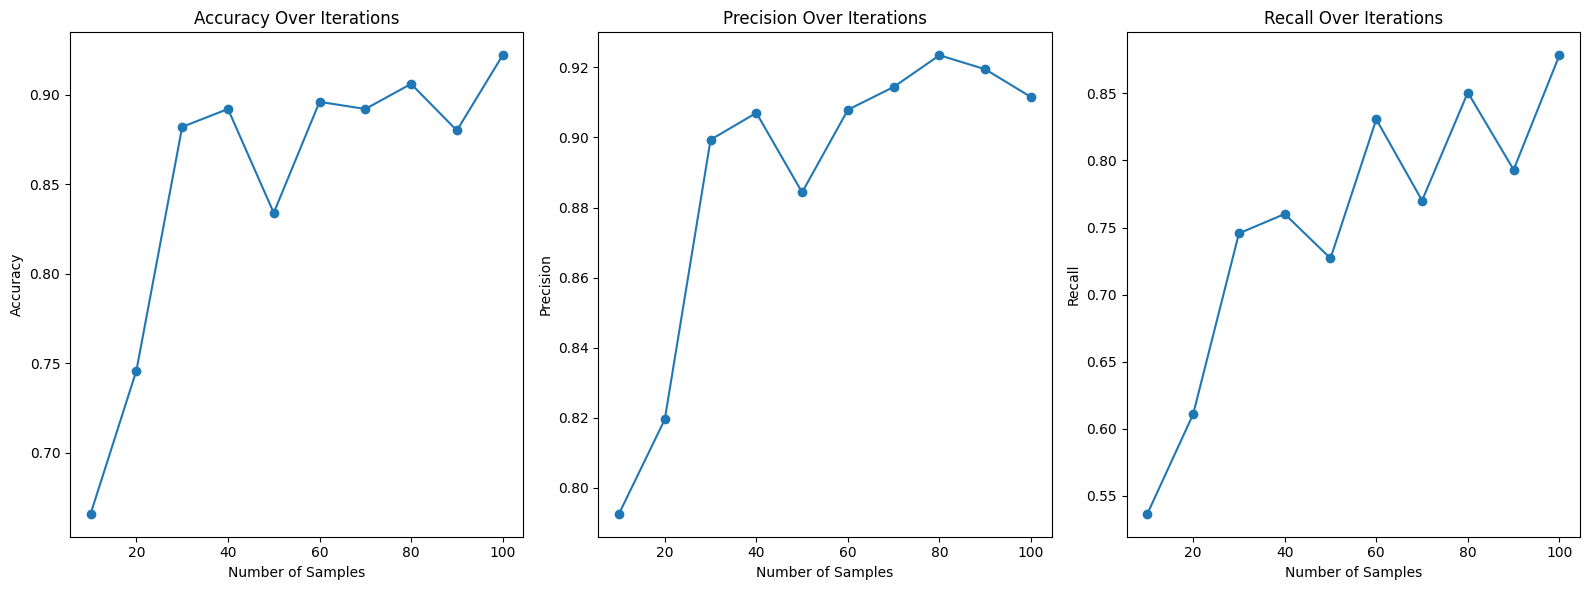

In [28]:
# Plot the metrics
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.plot(x_labels, accuracy_list, marker='o')
plt.title('Accuracy Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(x_labels, precision_list, marker='o')
plt.title('Precision Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Precision')

plt.subplot(1, 3, 3)
plt.plot(x_labels, recall_list, marker='o')
plt.title('Recall Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Recall')

plt.tight_layout()
plt.show()

In [29]:
predictions = trainer.predict(test_dataloader)
predicted_labels = predictions.predictions.argmax(axis=1)
accuracy = accuracy_score(test_df['coarse_label'].to_list(),predicted_labels)
print('accuracy {}% '.format(accuracy * 100))


  0%|          | 0/16 [00:00<?, ?it/s]

accuracy 92.2% 
